In [1]:
import dtale
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#################### IDEAS
# From Block, Lot and Borough CREATE a map to locate each building

In [ ]:
### URL datasets
# https://www.kaggle.com/muonneutrino/new-york-city-census-data
# https://www.kaggle.com/new-york-city/nyc-property-sales#nyc-rolling-sales.csv


### Giulio
# filename = "/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_Airbnb_2017.csv"
# filename1 = "/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_house_price.csv"

### Mattia
# filename = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_Airbnb_2017.csv"
# filename1 = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_house_price.csv"

In [2]:
# open csv

airbnb = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_Airbnb_2017.csv"
house_price = "/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/NYC_house_price.csv"
# non vedo grandi lavori di datacleaning. Ci ragioniamo più avanti in caso
df = pd.read_csv(airbnb, low_memory = False)
df_price = pd.read_csv(house_price)
df.shape

(45361, 96)

### List of Boroughs and Neighborhoods

In [ ]:
df_price.columns.values

### Price dataset requires some cleaning effort

In [3]:
# open NTC_house_price
mylist = df_price['NEIGHBORHOOD'].tolist()
mylist = list(dict.fromkeys(mylist))
print(mylist)

['ALPHABET CITY', 'CHELSEA', 'CHINATOWN', 'CIVIC CENTER', 'CLINTON', 'EAST VILLAGE', 'FASHION', 'FINANCIAL', 'FLATIRON', 'GRAMERCY', 'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST', 'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'HARLEM-WEST', 'INWOOD', 'JAVITS CENTER', 'KIPS BAY', 'LITTLE ITALY', 'LOWER EAST SIDE', 'MANHATTAN VALLEY', 'MIDTOWN CBD', 'MIDTOWN EAST', 'MIDTOWN WEST', 'MORNINGSIDE HEIGHTS', 'MURRAY HILL', 'ROOSEVELT ISLAND', 'SOHO', 'SOUTHBRIDGE', 'TRIBECA', 'UPPER EAST SIDE (59-79)', 'UPPER EAST SIDE (79-96)', 'UPPER EAST SIDE (96-110)', 'UPPER WEST SIDE (59-79)', 'UPPER WEST SIDE (79-96)', 'UPPER WEST SIDE (96-116)', 'WASHINGTON HEIGHTS LOWER', 'WASHINGTON HEIGHTS UPPER', 'BATHGATE', 'BAYCHESTER', 'BEDFORD PARK/NORWOOD', 'BELMONT', 'BRONX PARK', 'BRONXDALE', 'CASTLE HILL/UNIONPORT', 'CITY ISLAND', 'CITY ISLAND-PELHAM STRIP', 'CO-OP CITY', 'COUNTRY CLUB', 'CROTONA PARK', 'EAST RIVER', 'EAST TREMONT', 'FIELDSTON', 'FORDHAM', 'HIGHBRIDGE/MORRIS HEIGHTS', 'HUNTS POI

In [ ]:
# get the shape
df_price

In [ ]:
# get the dimension
df_price.ndim

In [ ]:
# check the datatype of each colum to avoid surprise
df_price.dtypes

In [ ]:
# description of every column
df_price.info()

In [4]:
# quick overview about key indicators
df_price.describe()

,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000
mean,10344.359878,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,1789.322976,1.657485
std,7151.779436,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,537.344993,0.819341
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4231.000000,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000
50%,8942.000000,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000
75%,15987.250000,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000
max,26739.000000,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000


In [5]:
# Drop EASE-MENT column since it is empty, and UNNAMED: 0
del df_price["EASE-MENT"]
del df_price["Unnamed: 0"]

In [6]:
# Change columns' names in order to have lower case and no spasce between words
df_price = df_price.rename(columns=str.lower)
df_price.columns = df_price.columns.str.replace(' ', '_')

# Check for and eventually remove rows that are duplicates

if sum(df_price.duplicated(df_price.columns)) > 0:
    df_price = df_price.drop_duplicates(df_price.columns, keep="last")
    
# sum(df_price.duplicated(df_price.columns))

## Columns that are made only of strings with no misleading values:
# "borough", "neighborhood" and "building_class_category", "address", "apartment_number", "building_class_at_time_of_sale",
#"sale_date"

## Columns that are made only of integers with no misleading values
# "block", "lot", "zip_code", "residential_units", "commercial_units", "total_units", "tax_class_at_time_of_sale"

# Replace a precise value in this column, which we are sure is not in the column, then drop those rows
df_price["sale_price"] = df_price["sale_price"].replace(' -  ', "%%%%")

######## ARE THOSE LINES TO BE DROPPED OR TO ADD THE MEAN
df_price.drop(df_price[df_price.sale_price == "%%%%"].index, inplace = True)

# Convert all the remaining values to float
df_price['sale_price']= pd.to_numeric(df_price['sale_price'], errors='raise')

# Replace given string with nan
df_price['tax_class_at_present'] = df_price['tax_class_at_present'].replace(" " , np.nan)
df_price['building_class_at_present'] = df_price['building_class_at_present'].replace(" " , np.nan)
df_price['year_built'] = df_price['year_built'].replace(0 , np.nan)


########## MISS LAND SQUARE FEET AND GROSS SQUARE FEET

In [29]:
#print( sorted(list(dict.fromkeys(df_price["year_built"].tolist()))) )
#print( [type(x) for x in list(dict.fromkeys(df_price["land_square_feet"].tolist()))] )
#print( len([x for x in df_price["land_square_feet"].tolist() if x == ' -  ']) )

In [26]:
df_price.dtypes

borough                            int64
neighborhood                      object
building_class_category           object
tax_class_at_present              object
block                              int64
lot                                int64
building_class_at_present         object
address                           object
apartment_number                  object
zip_code                           int64
residential_units                  int64
commercial_units                   int64
total_units                        int64
land_square_feet                  object
gross_square_feet                 object
year_built                         int64
tax_class_at_time_of_sale          int64
building_class_at_time_of_sale    object
sale_price                         int64
sale_date                         object
dtype: object

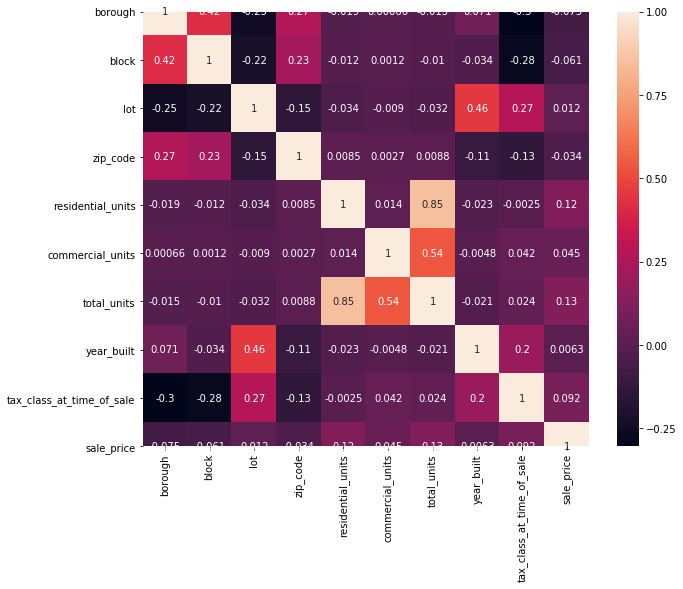

In [34]:
plt.figure(figsize = (10,8))
corr = df_price.corr()
sns.heatmap(corr, annot = True)

In [46]:
df_sliced = df_price["sale_price"].copy()
df_sliced_list = [x for x in df_sliced.tolist() if 100000 < x < 10000000]
print(len(df_sliced_list))

55981


In [54]:
# df_price.shape
print(round((69607-55981)/69607*100, 2))

19.58


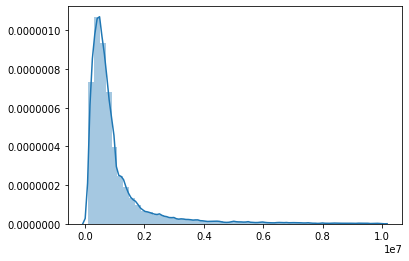

In [55]:
sns.distplot(df_sliced_list)